## 0. Import Libraries/Modules

In [1]:
from utils import *
from models import *

In [2]:
PATH = os.path.join(os.getcwd(), "pickle")
if not os.path.exists(PATH):
    os.mkdir(PATH)

In [3]:
%pip install einops
!pip3 install --upgrade gdown --quiet
!gdown 1tHHD_wkOREgBSYpC0DqPeKIktx9G3P5X

Note: you may need to restart the kernel to use updated packages.


Downloading...
From: https://drive.google.com/uc?id=1tHHD_wkOREgBSYpC0DqPeKIktx9G3P5X
To: c:\Users\18242\Documents\GitHub\PIC16B-Project\Project\data.tar.gz

  0%|          | 0.00/62.7M [00:00<?, ?B/s]
  7%|▋         | 4.19M/62.7M [00:00<00:01, 40.3MB/s]
 12%|█▏        | 7.34M/62.7M [00:00<00:01, 33.5MB/s]
 21%|██        | 13.1M/62.7M [00:00<00:01, 37.6MB/s]
 28%|██▊       | 17.8M/62.7M [00:00<00:01, 39.0MB/s]
 38%|███▊      | 23.6M/62.7M [00:00<00:00, 42.0MB/s]
 47%|████▋     | 29.4M/62.7M [00:00<00:00, 45.0MB/s]
 56%|█████▌    | 35.1M/62.7M [00:00<00:00, 46.3MB/s]
 67%|██████▋   | 41.9M/62.7M [00:00<00:00, 50.9MB/s]
 78%|███████▊  | 48.8M/62.7M [00:01<00:00, 53.8MB/s]
 87%|████████▋ | 54.5M/62.7M [00:01<00:00, 53.7MB/s]
 96%|█████████▌| 60.3M/62.7M [00:01<00:00, 53.7MB/s]
100%|██████████| 62.7M/62.7M [00:01<00:00, 49.7MB/s]


In [4]:
root_dir = './'
os.makedirs(os.path.join(root_dir, 'data'), exist_ok=True)

tar = tarfile.open("data.tar.gz", "r:gz")
total_size = sum(f.size for f in tar.getmembers())
with tqdm(total=total_size, unit="B", unit_scale=True, desc="Extracting tar.gz file") as pbar:
    for member in tar.getmembers():
        tar.extract(member, os.path.join(root_dir, 'data'))
        pbar.update(member.size)

# Close the tar.gz file
tar.close()

Extracting tar.gz file: 100%|██████████| 69.6M/69.6M [01:08<00:00, 1.01MB/s]


## 1. Data Exploration
### 1-1. Sample Images

In [5]:
root_dir = os.path.join(root_dir, 'data', 'images')
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

These are the facial expressions we're trying to detect

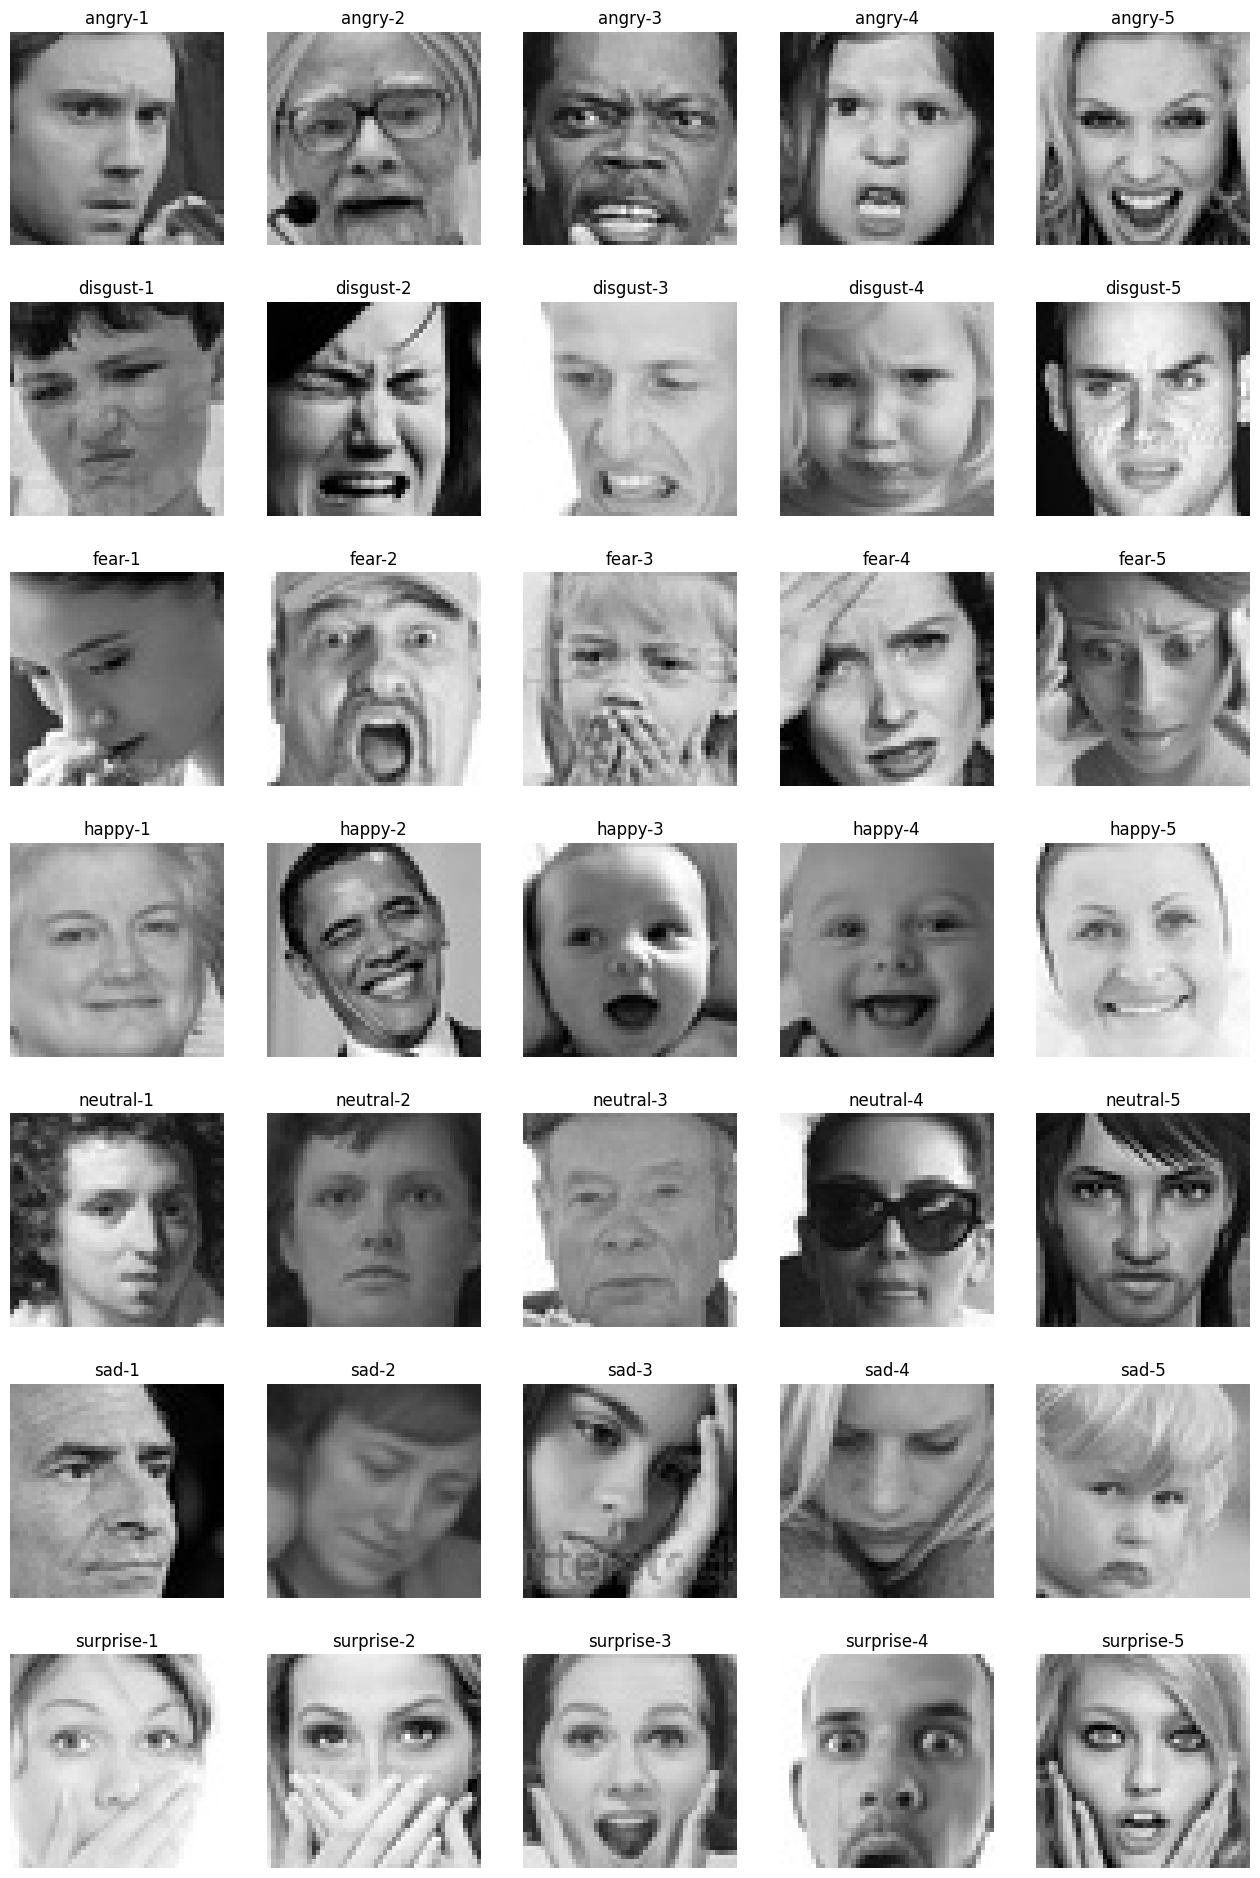

In [6]:
show_examples(train_dir)

### 1-2. Number of Images in Each Category

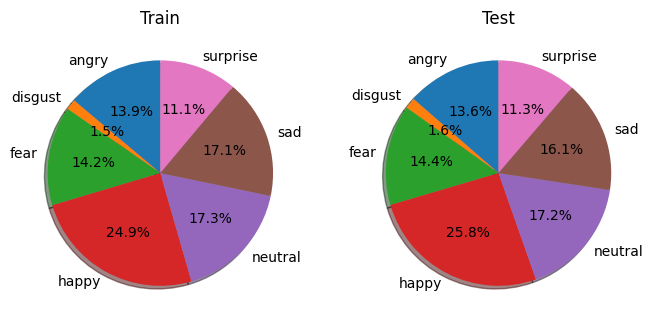

Emotion : angry
	Training : 3994
	 Testing : 960
Emotion : disgust
	Training : 436
	 Testing : 111
Emotion : fear
	Training : 4103
	 Testing : 1018
Emotion : happy
	Training : 7164
	 Testing : 1825
Emotion : neutral
	Training : 4982
	 Testing : 1216
Emotion : sad
	Training : 4938
	 Testing : 1139
Emotion : surprise
	Training : 3205
	 Testing : 797


In [7]:
show_distribution(train_dir, test_dir)

### Define Data Transform

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    
    # Normalize image using ImageNet statistics
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

### Train, Validation Split

In [9]:
trainset = ImageFolder(train_dir, transform=data_transform)

val_size = int(len(trainset)/10)
train_size = len(trainset) - val_size

train_dataset, val_dataset = random_split(trainset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(25939, 2882)

In [10]:
test_dataset = ImageFolder(test_dir, transform = data_transform)

### Define the Train Method

In [11]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f'Using device: {device}, Good to go!')
else:
    print('GPU not available')

GPU not available


In [12]:
!nvidia-smi

Wed Mar 22 02:19:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   61C    P8    15W / 100W |    380MiB /  8192MiB |     33%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Build the ResNet

### Pretrained ResNet features + Linear Classifier

In [18]:
# Define the model, optimizer, and criterion
linear1 = Resnet(mode='linear', pretrained=True)

optimizer = torch.optim.SGD(
    linear1.parameters(),
    lr=0.005,
    momentum=0.9
)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)


model_name = "linear1.pt"
try:
  if device == torch.device('cuda'):
    linear1.load_state_dict(torch.load(os.path.join(PATH, model_name))
  else:
     linear1.load_state_dict(torch.load(os.path.join(PATH, model_name), map_location=torch.device('cpu')))
except:
  train(linear1, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)
torch.save(linear1.state_dict(), os.path.join(PATH, model_name))

### Finetune pretrained ResNet

#### Fully finetune with same learning rate

In [19]:
resnet_finetune1 = Resnet(mode='finetune', pretrained=True)

optimizer = torch.optim.SGD(
    resnet_finetune1.parameters(),
    lr = 0.01,
    momentum=0.9
)

criterion = nn.CrossEntropyLoss()

batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)


model_name = "resnet_finetune1.pt"
try:
  if device == torch.device('cuda'):
     resnet_finetune1.load_state_dict(torch.load(os.path.join(PATH, model_name))
  else:
     resnet_finetune1.load_state_dict(torch.load(os.path.join(PATH, model_name), map_location=torch.device('cpu')))
except:
  train(resnet_finetune1, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)
torch.save(resnet_finetune1.state_dict(), os.path.join(PATH, model_name))

#### Fully finetune with different learning rates

Lower layers in a network typically learn low-level features such as edges and textures that are useful across a wide range of tasks, and therefore may require smaller updates to prevent overfitting. Meanwhile, higher layers may learn more task-specific features that require larger updates to improve performance.

In [20]:
resnet_finetune2 = Resnet(mode='finetune', pretrained=True)

last_params, rest_params = [], []
for name, param in resnet_finetune2.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

criterion = nn.CrossEntropyLoss()


batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)

model_name = "resnet_finetune2.pt"
try:
  if device == torch.device('cuda'):
     resnet_finetune2.load_state_dict(torch.load(os.path.join(PATH, model_name))
  else:
     resnet_finetune2.load_state_dict(torch.load(os.path.join(PATH, model_name), map_location=torch.device('cpu')))
except:
  train(resnet_finetune2, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)
torch.save(resnet_finetune2.state_dict(), os.path.join(PATH, model_name))

#### Finetune with few frozen layers
Freezing some layers during fine-tuning can help to provent overfitting and speed up the training process. When we fine-tune a pre-trained neural network, we typically want to retain the learned feature representations in the lower layers of the network, which are often more general and transferable across different tasks. By freezing these lower layers, we prevent their weights from being updated during fine-tuing, which helps to ensure that the model retains its learned feature representations. This can be particularly important if we have a small amount of data available for the specific task we are fine-tuning for.

In [21]:
'''
Setting lr to 0.01 for the last fc lyaer.
Setting lr to 0 for the resnet.layer1 and resnet.layer2 layers.
Setting lr to 0.001 for the rest layers.
'''

resnet_finetune3 = Resnet(mode='finetune', pretrained=True)

last_params, lower_params, rest_params = [], [], []

for name, param in resnet_finetune3.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    elif 'layer1' in name or 'layer2' in name:
        lower_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": lower_params, "lr": 0, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2
# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model

model_name = "resnet_finetune3.pt"
try:
  if device == torch.device('cuda'):
     resnet_finetune3.load_state_dict(torch.load(os.path.join(PATH, model_name))
  else:
     resnet_finetune3.load_state_dict(torch.load(os.path.join(PATH, model_name), map_location=torch.device('cpu')))
except:
  train(resnet_finetune3, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)
torch.save(resnet_finetune3.state_dict(), os.path.join(PATH, model_name))

### Image Augmentation to avoid Overfitting

#### Original Image

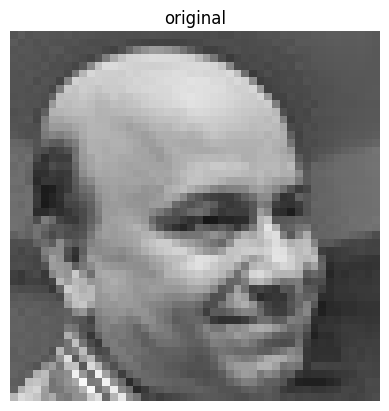

In [22]:
fig  = plt.plot(figsize=(5,5))

target_var = os.listdir(train_dir)
image = cv2.imread(os.path.join(train_dir, target_var[3], os.listdir(os.path.join(train_dir, target_var[3]))[12]))
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
plt.axis('off')
plt.title('original')

plt.show()
        

#### Gaussian Blur

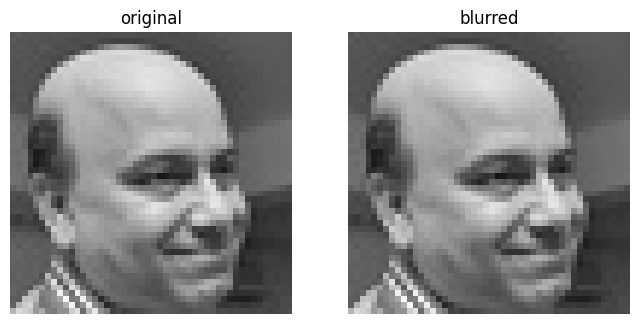

In [23]:
from numpy import asarray

blurrer = transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,0.2))

fig, axes = plt.subplots(1, 2, figsize = (8, 4))

image = Image.open(os.path.join(train_dir, target_var[3], os.listdir(os.path.join(train_dir, target_var[3]))[12]))
image = asarray(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
axes[0].imshow(image)
axes[0].set_title('original')
axes[0].axis('off')

image = torch.tensor(image)
image = blurrer(image)
image = asarray(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
axes[1].imshow(image)
axes[1].set_title('blurred')
axes[1].axis('off')

plt.show()

#### Rotation

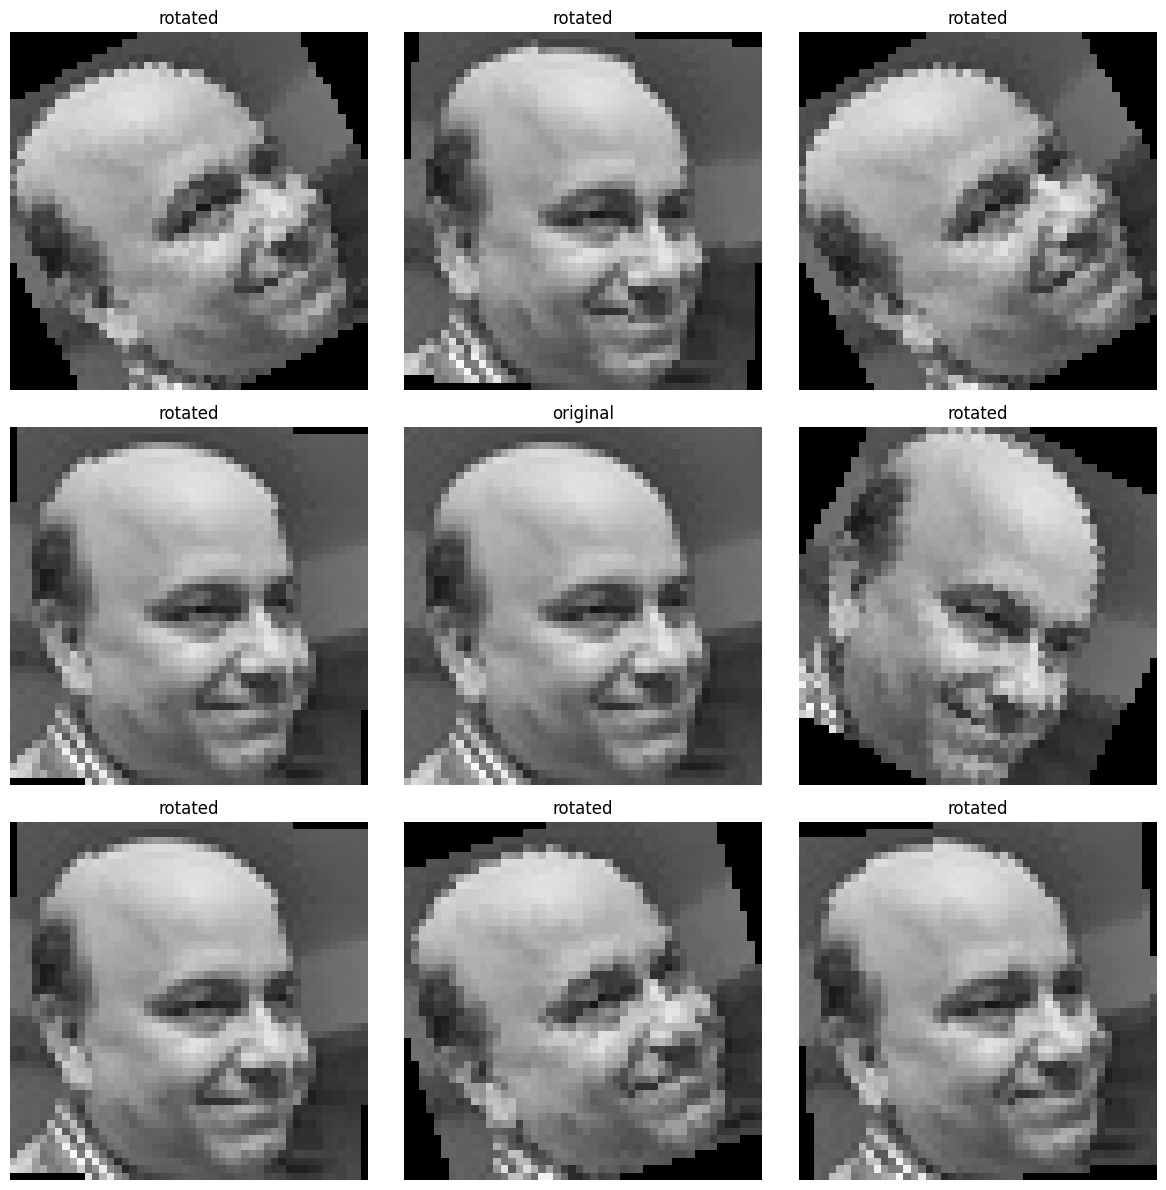

In [24]:
image_rotate = transforms.RandomRotation((-30, 30))

fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        image = Image.open(os.path.join(train_dir, target_var[3], os.listdir(os.path.join(train_dir, target_var[3]))[12]))
        if i != 1 or j != 1:
            image = image_rotate(image)
        image = asarray(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        axes[i][j].imshow(image)

        if i == 1 and j == 1:
            axes[i][j].set_title('original')
        else:
            axes[i][j].set_title('rotated')
        axes[i][j].axis('off')

plt.tight_layout()
plt.show()

#### Flips

In [25]:
image_hflip = transforms.RandomHorizontalFlip(p=1)
image_vflip = transforms.RandomVerticalFlip(p=1)

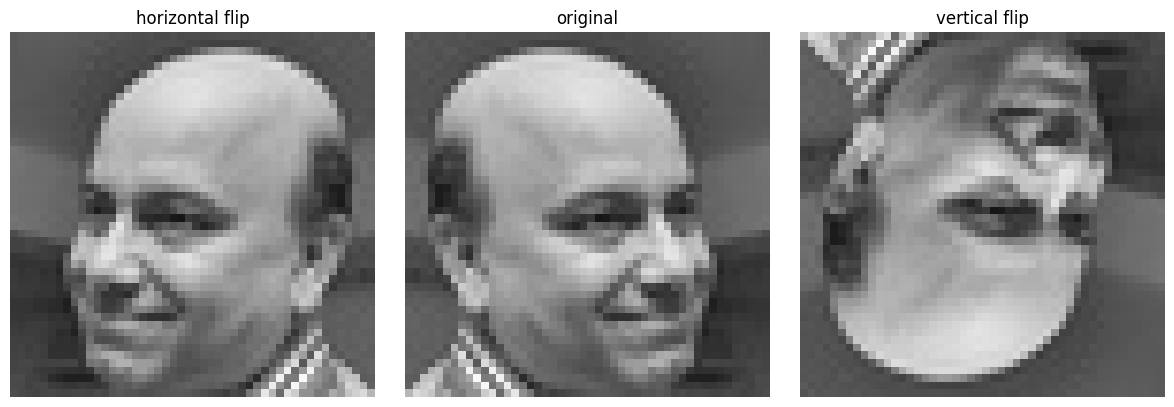

In [26]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
for i in range(3):
    image = Image.open(os.path.join(train_dir, target_var[3], os.listdir(os.path.join(train_dir, target_var[3]))[12]))
    if i == 0:
        image = image_hflip(image)
    
    if i == 2:
        image = image_vflip(image)

    image = asarray(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)

    if i == 0:
        axes[i].set_title('horizontal flip')
    elif i == 1:
        axes[i].set_title('original')
    else:
        axes[i].set_title('vertical flip')
    
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Random Perspective

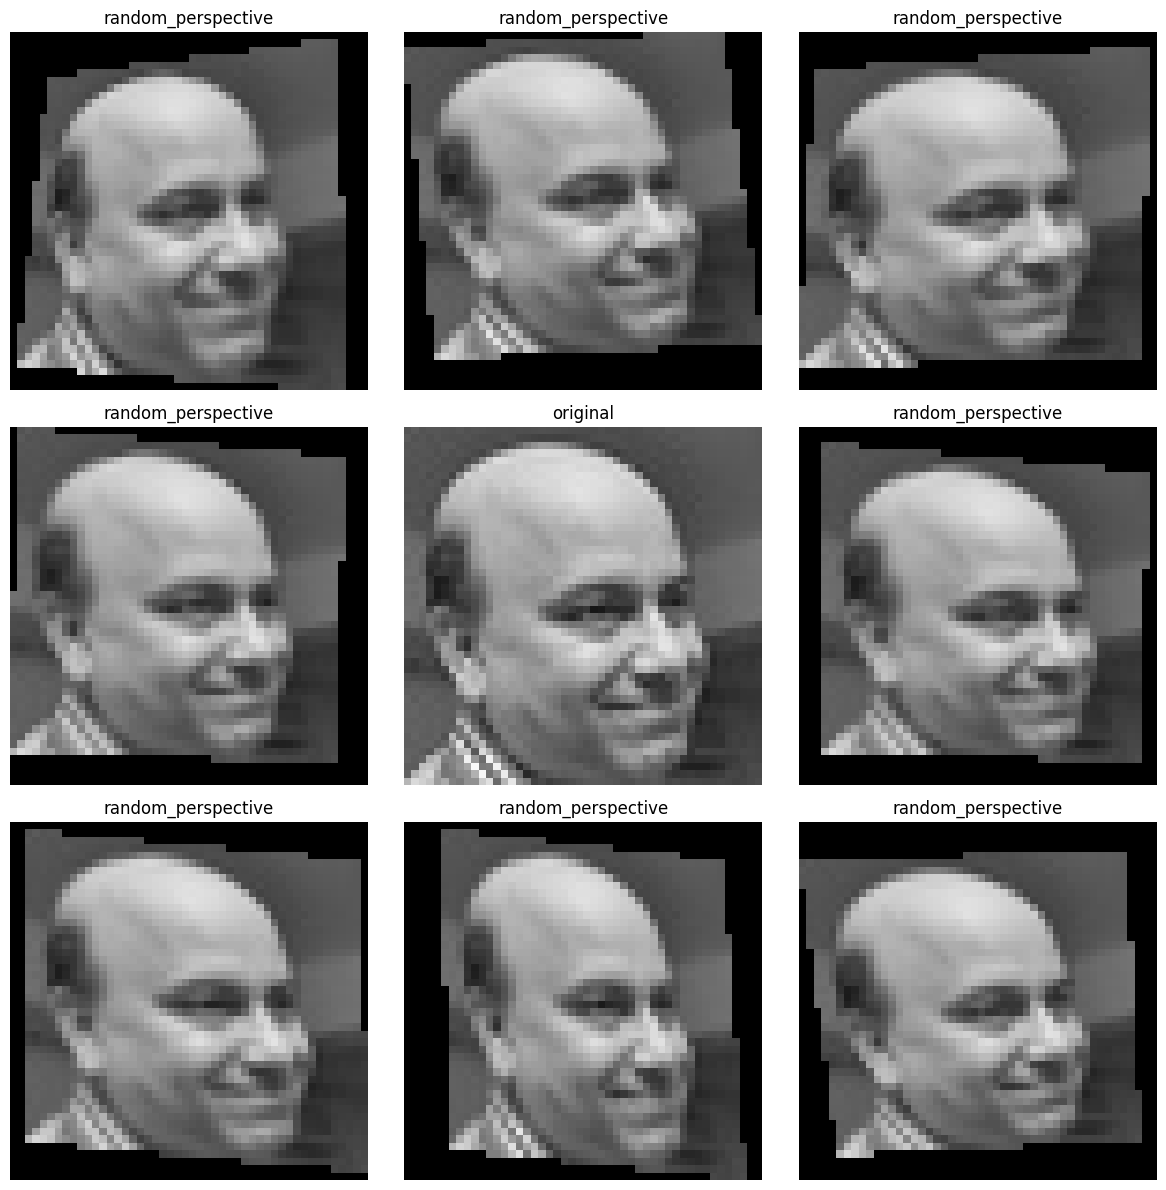

In [27]:
image_randomP = transforms.RandomPerspective(distortion_scale=0.25, p=1)

fig, axes = plt.subplots(3,3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        image = Image.open(os.path.join(train_dir, target_var[3], os.listdir(os.path.join(train_dir, target_var[3]))[12]))
        if i != 1 or j != 1:
            image = image_randomP(image)
        image = asarray(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(image)
        if i == 1 and j == 1:
            axes[i][j].set_title('original')
        else:
            axes[i][j].set_title('random_perspective')
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [28]:
'''
Setting lr to 0.01 for the last fc lyaer.
Setting lr to 0 for the resnet.layer1 and resnet.layer2 layers.
Setting lr to 0.001 for the rest layers.
'''

resnet_finetune4 = Resnet(mode='finetune', augmented = True, pretrained=True)

last_params, rest_params = [], []
for name, param in resnet_finetune4.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)


criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2
# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# Train the model
model_name = "resnet_finetune4.pt"
try:
  if device == torch.device('cuda'):
     resnet_finetune4.load_state_dict(torch.load(os.path.join(PATH, model_name))
  else:
     resnet_finetune4.load_state_dict(torch.load(os.path.join(PATH, model_name), map_location=torch.device('cpu')))
except:
  train(resnet_finetune4, train_loader, val_loader, optimizer, criterion, device, num_epochs=20)

torch.save(resnet_finetune4.state_dict(), os.path.join(PATH, model_name))

In [29]:
'''
Setting lr to 0.01 for the last fc lyaer.
Setting lr to 0 for the resnet.layer1 and resnet.layer2 layers.
Setting lr to 0.001 for the rest layers.
'''

resnet_finetune5 = Resnet(mode='finetune', augmented = True, pretrained=True)

last_params, lower_params, rest_params = [], [], []

for name, param in resnet_finetune5.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    elif 'layer1' in name or 'layer2' in name:
        lower_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": lower_params, "lr": 0, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2
# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# Train the model
model_name = "resnet_finetune5.pt"
try:
  if device == torch.device('cuda'):
     resnet_finetune5.load_state_dict(torch.load(os.path.join(PATH, model_name)))
  else:
     resnet_finetune5.load_state_dict(torch.load(os.path.join(PATH, model_name), map_location=torch.device('cpu')))
except:
    train(resnet_finetune5, train_loader, val_loader, optimizer, criterion, device, num_epochs=20)

torch.save(resnet_finetune5.state_dict(), os.path.join(PATH, model_name))

In [30]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

In [31]:
pred_labels = test_evaluate(resnet_finetune4, test_loader, device)

In [32]:
count = 0
true_labels = []
for i in range(len(pred_labels)):
    true_labels.append(test_dataset[i][1])
    if pred_labels[i] == test_dataset[i][1]:
        count += 1

print(count / len(pred_labels))

0.6235493914520238


In [33]:
class2label = test_dataset.class_to_idx
label2class = {v: k for k, v in class2label.items()}

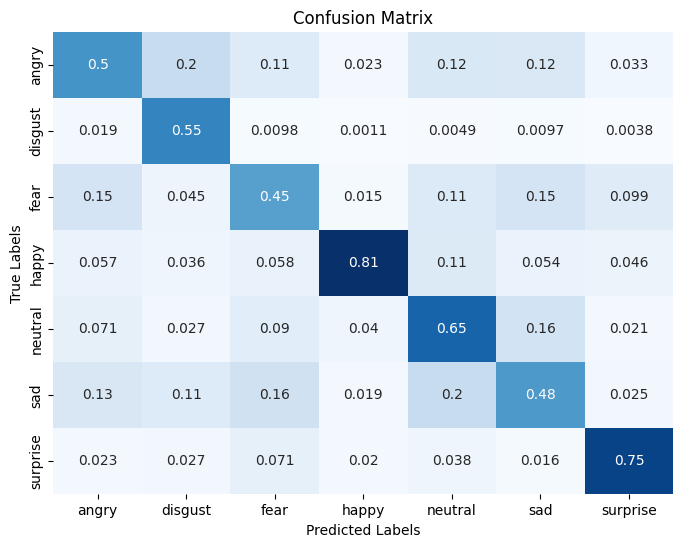

In [34]:
cm = confusion_matrix(true_labels, pred_labels)
cm = cm/cm.astype(float).sum(axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=label2class.values(),yticklabels=label2class.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Evaluate sample images and visualize the predicted fraction of each facial expression:

In [35]:
inputs, true_labels, pred_fractions, pred_labels = eval_sample_inputs(resnet_finetune4, test_loader, device, seed=0)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000020110A8FAF0>
Traceback (most recent call last):
  File "c:\miniconda\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "c:\miniconda\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


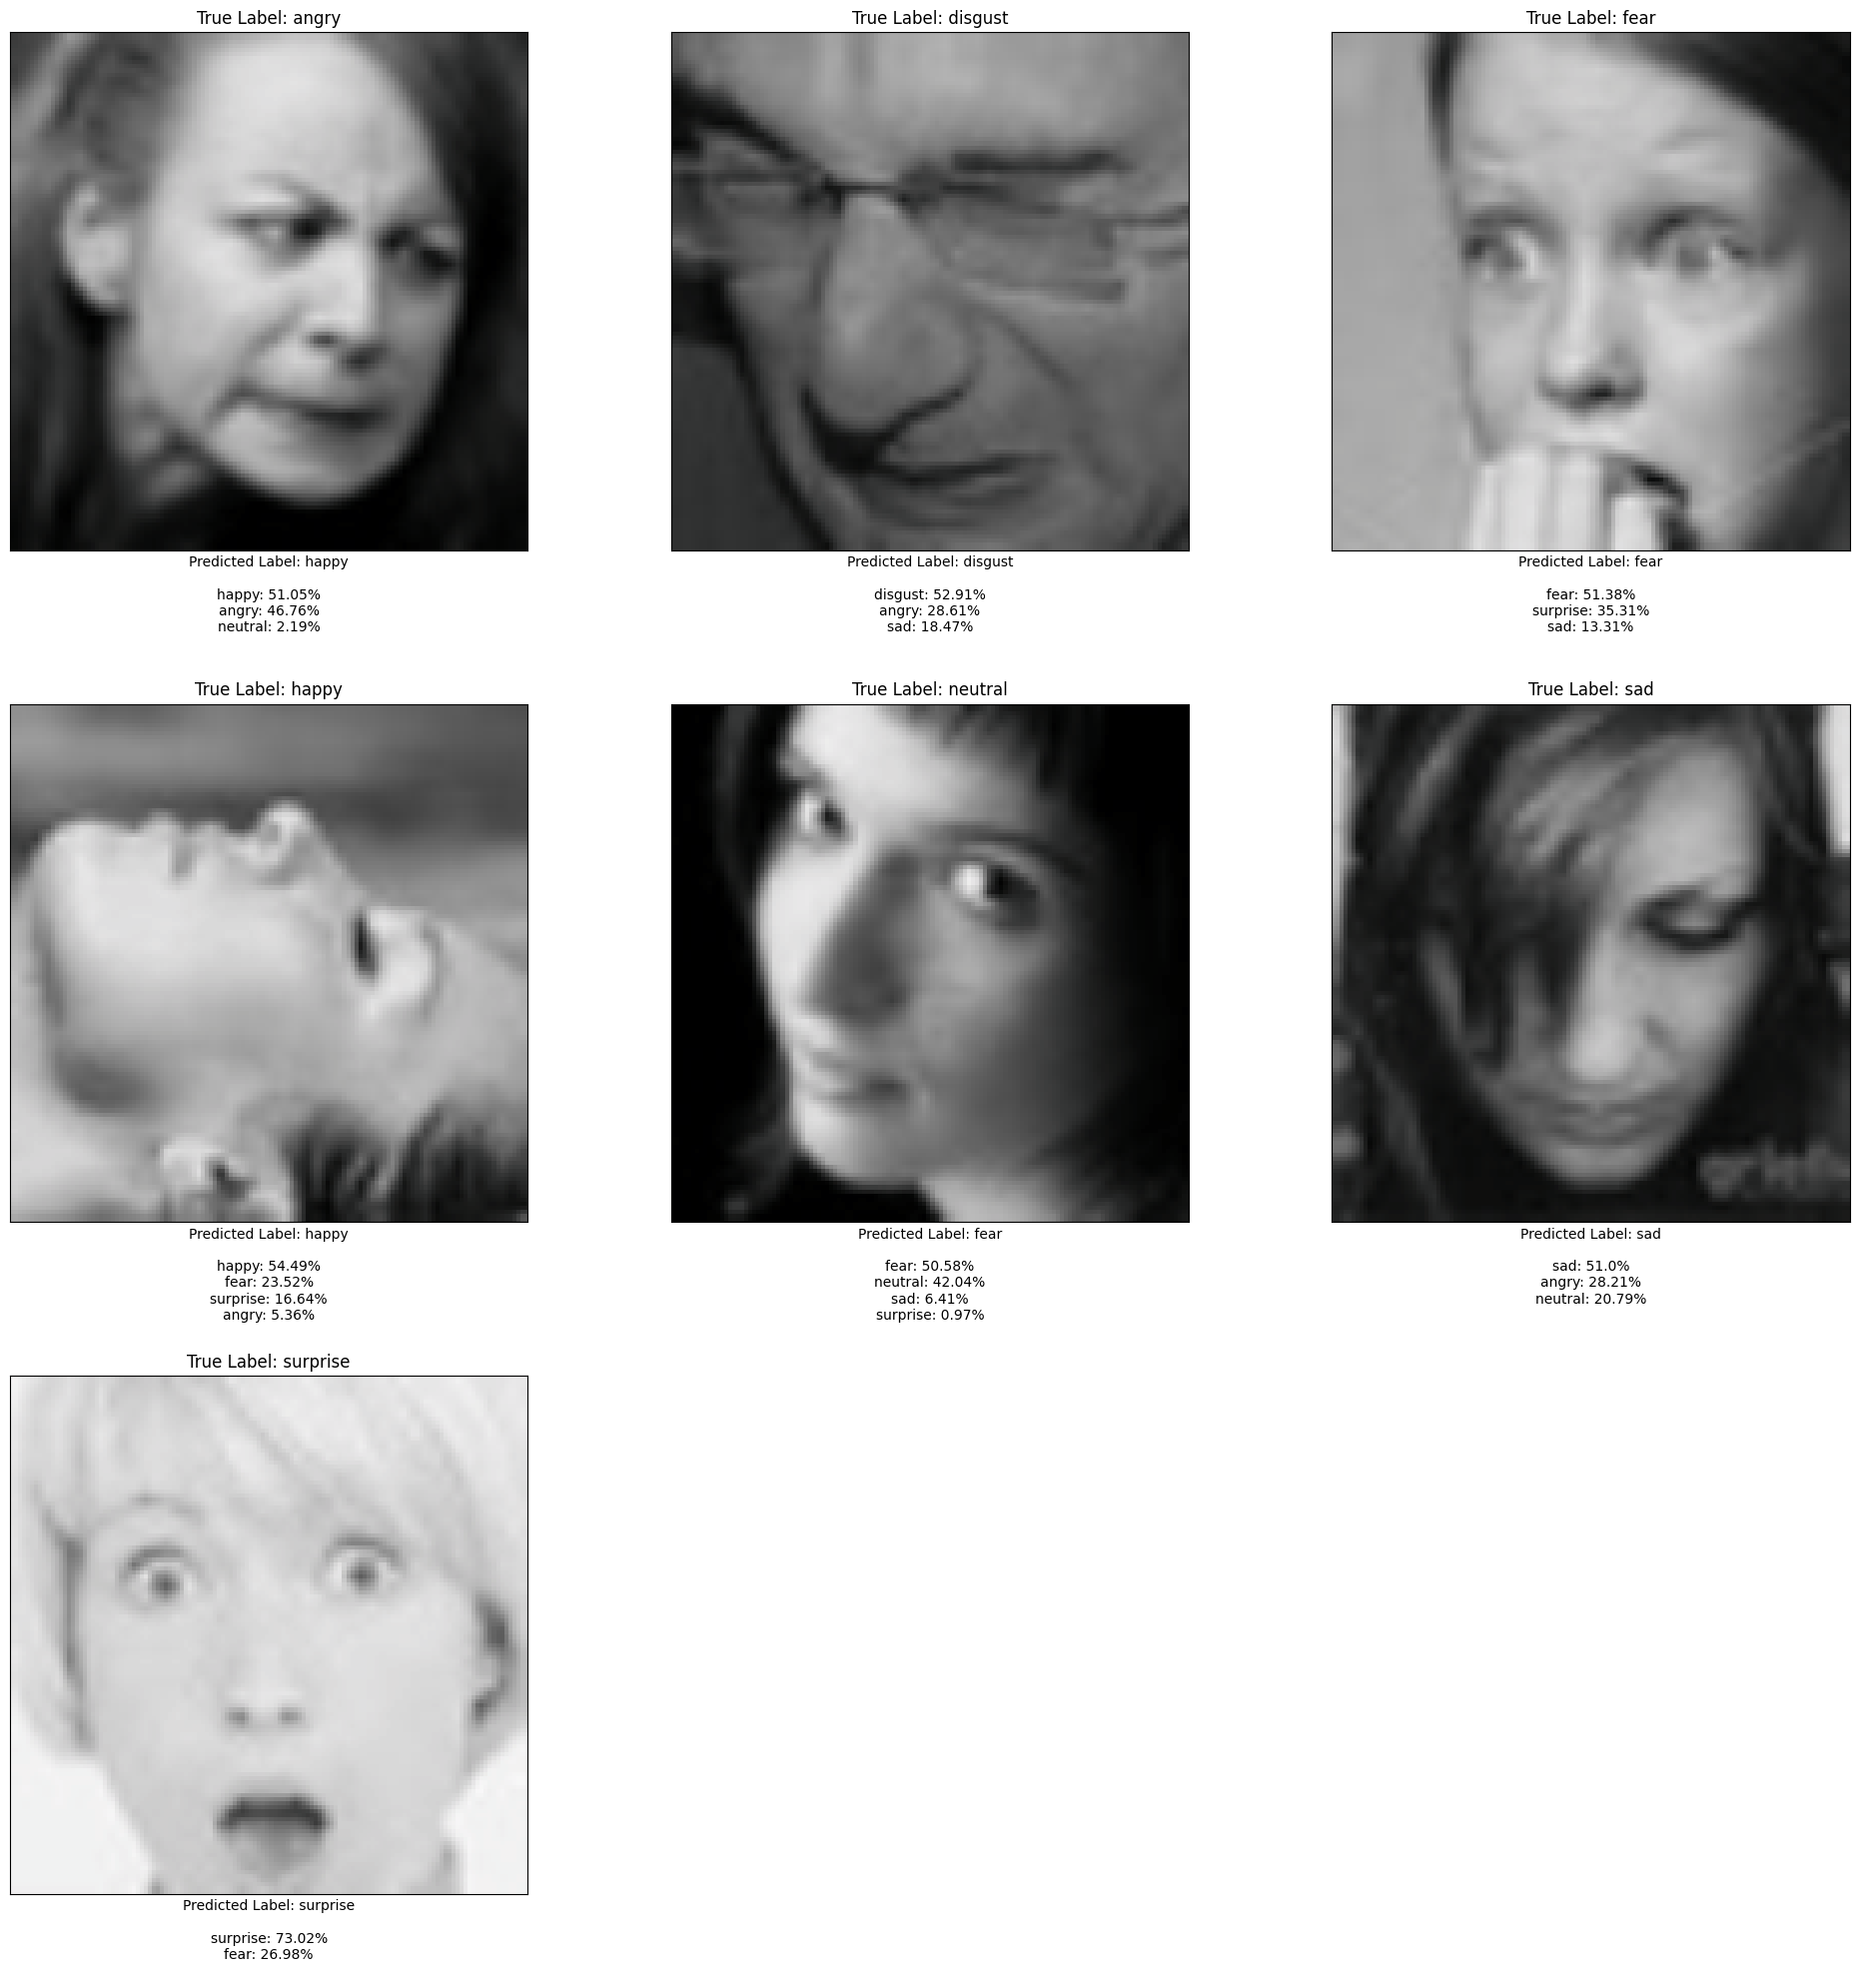

In [36]:
show_samples(inputs, true_labels, pred_fractions, pred_labels, label2class, class2label)

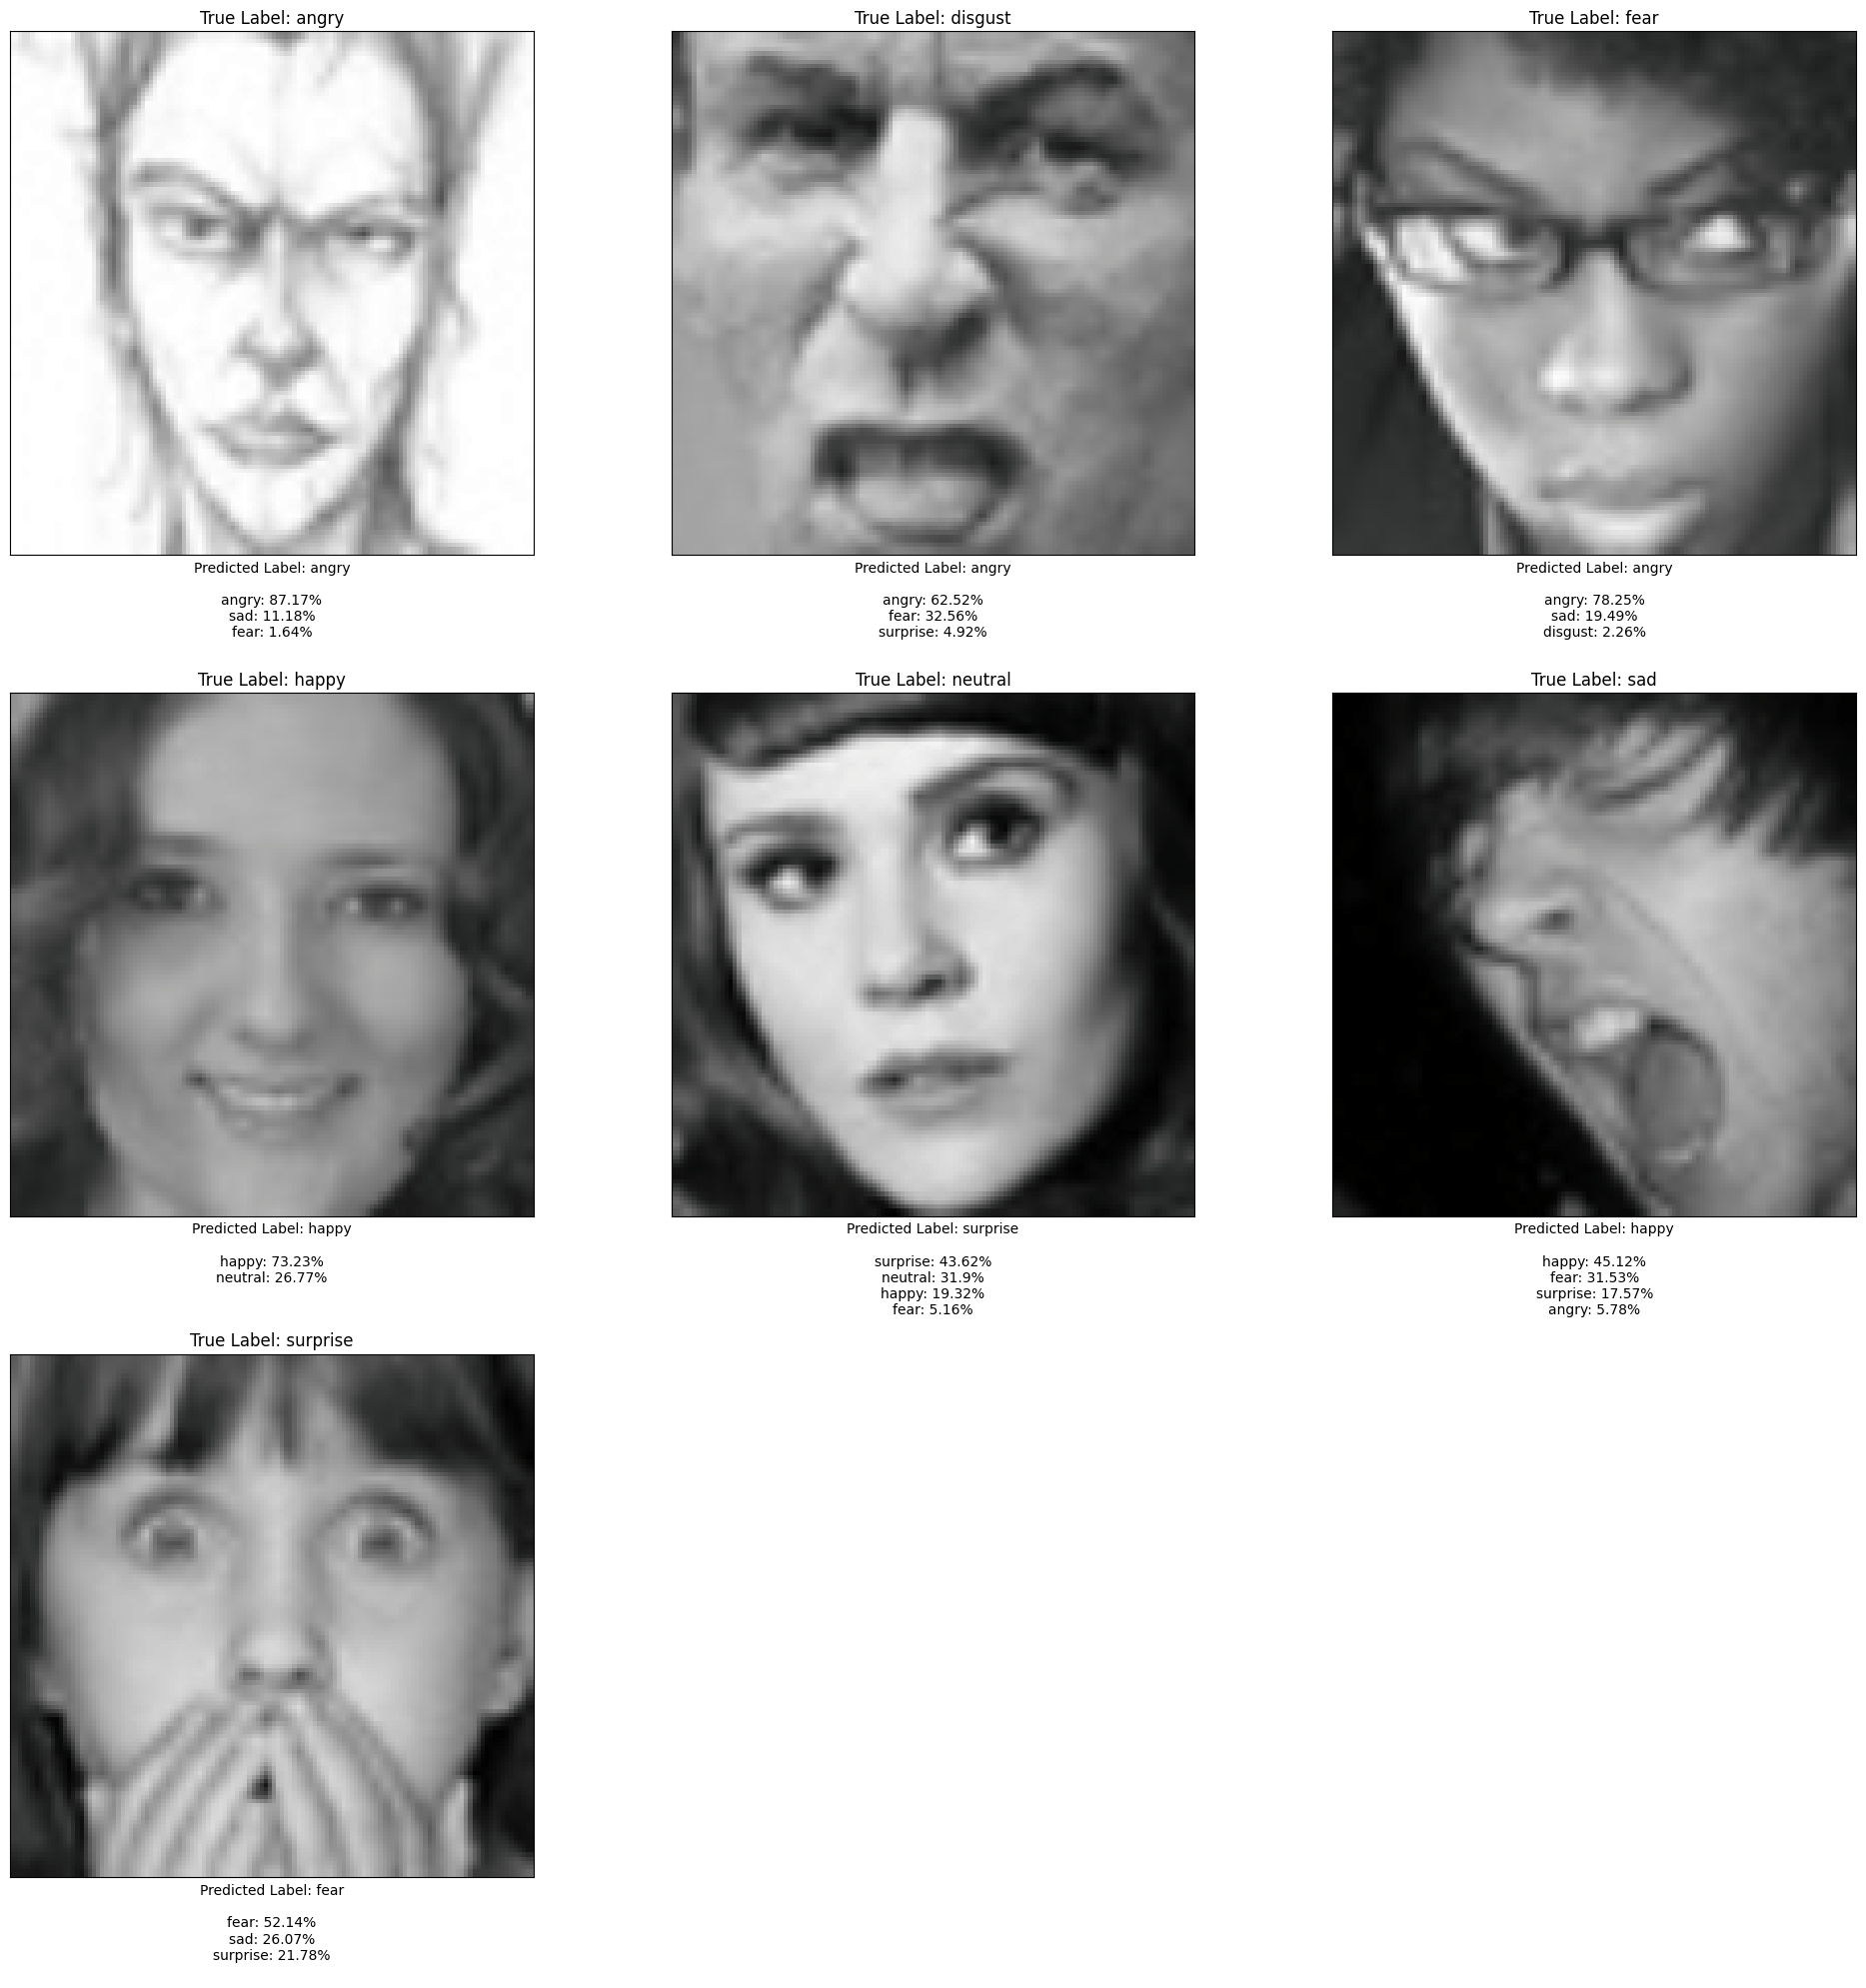

In [37]:
inputs, true_labels, pred_fractions, pred_labels = eval_sample_inputs(resnet_finetune3, test_loader, device, seed=10)
show_samples(inputs, true_labels, pred_fractions, pred_labels, label2class, class2label)